# Companion Notebook to `playing-with-coronavirus-data` 
- [GitHub Repo](https://github.com/jirvingphd/playing-with-coronavirus-data)
- James M. Irivng, Ph.D.
- james.irving.phd@gmail.com

# Business Problem

- Covid-19 and the various strains that have since emerged has upended modern life and fundamental changed how we function as a society.
- Part of what has made it difficult to tackle the pandemic is due to differences between states, state laws/policies, and a lack of public understanding about the predictability of the surges in cases. 


### Goal

- The goal of this notebook is to produce a workflow for producing forecasts of the following metrics at least 1 week ahead of time. 
    - Confirmed Cases
    - Number of Deaths
    - ICU Capacity
    
- The stretch goal for the project is to create a streamlit dashboard for getting state-level forecasts for any state in the US, using fresh daily data.
    

### Methodology

- To select 3-5 prototypical states representing very different time courses/
- Initial Thoughts:
    - NY
    - TX
    - FL
    - MD
    - LA

# Data

- See `Data Acquisition.py` and `Replacing Covid Tracking Project Data_08-2021.ipynb` for details (for now)


In [26]:
## Uncomment Cell to acquire new data
# !python data_acquisition.py

fsds v0.3.2 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 
covid19-data-from-john-hopkins-university.zip: Skipping, found more recently modified local copy (use --force to force download)
[i] Page 0
 - offset = 0
[i] Page 1
 - offset = 1000
[i] Page 2
 - offset = 2000
[i] Page 3
 - offset = 3000
[i] Page 4
 - offset = 4000
[i] Page 5
 - offset = 5000
[i] Page 6
 - offset = 6000
[i] Page 7
 - offset = 7000
[i] Page 8
 - offset = 8000
[i] Page 9
 - offset = 9000
[i] Page 10
 - offset = 10000
[i] Page 11
 - offset = 11000
[i] Page 12
 - offset = 12000
[i] Page 13
 - offset = 13000
[i] Page 14
 - offset = 14000
[i] Page 15
 - offset = 15000
[i] Page 16
 - offset = 16000
[i] Page 17
 - offset = 17000
[i] Page 18
 - offset = 18000
[i] Page 19
 - offset = 19000
[i] Page 20
 - offset = 20000
[i] Page 21
 - offset = 21000
[i] Page 22
 - offset = 22000
[i] Page 23
 - offset = 23000
[i] Page 24
 - offset = 24000
[i] Page 25
 - offset = 25000
[i] Page 26
 - offset = 26000
[i] Pag

In [42]:
# !pip install fsds
# !pip install pmdarima

from fsds.imports import *
import os,glob,sys
import re

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_dark"

plt.rcParams['figure.figsize'] = (12,6)
pd.set_option('display.max_columns',0)

import statsmodels.tsa.api as tsa

In [58]:
%load_ext autoreload 
%autoreload 2
import coronavirus_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


> Data is stored as both separate csvs for each state as well as one big dictionary in a joblib file.

#### CSV Data

In [28]:
import glob
query = "./data/combined_*.csv.gz"
# os.listdir('data/')
file_list = glob.glob(query)
file_list[:5]

['./data/combined_data_PR.csv.gz',
 './data/combined_data_FL.csv.gz',
 './data/combined_data_NV.csv.gz',
 './data/combined_data_MD.csv.gz',
 './data/combined_data_KS.csv.gz']

#### Joblib Data

In [29]:
import joblib
STATES = joblib.load('data/STATE_DICT.joblib')
STATES.keys()

dict_keys(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'])

# EDA

## Selecting Prototypical States

In [30]:
def get_state(STATES, state='NY'):
    df_state= STATES[state].copy()
    cols_to_drop=[c for c in df_state.columns if ('coverage' in c) | ('denominator' in c)]
    df_state = df_state.drop(columns=cols_to_drop)
    return df_state

### NY

In [31]:
ny = get_state(STATES,'NY')
ny

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_numerator,adult_icu_bed_utilization,adult_icu_bed_utilization_numerator
date,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...
2021-08-06,3739.0,3.0,0.781316,39751.0,0.658052,3412.0
2021-08-07,4491.0,35.0,0.779076,39059.0,0.658556,3383.0
2021-08-08,3578.0,15.0,0.000000,0.0,0.000000,0.0


In [32]:
## make subplotsplot of time series # of cases vs utilization 
df_state = ny.copy()
drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
# df_state.drop(columns=drop_cols,inplace=True)
util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
other_cols = [c for c in df_state.columns if c not in util_cols]
util_cols

['inpatient_beds_utilization', 'adult_icu_bed_utilization']

In [33]:
df_state

,# Cases,# Deaths,inpatient_beds_utilization,inpatient_beds_utilization_numerator,adult_icu_bed_utilization,adult_icu_bed_utilization_numerator
date,,,,,,
2020-01-22,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-23,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-24,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-25,0.0,0.0,0.000000,0.0,0.000000,0.0
2020-01-26,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...
2021-08-06,3739.0,3.0,0.781316,39751.0,0.658052,3412.0
2021-08-07,4491.0,35.0,0.779076,39059.0,0.658556,3383.0
2021-08-08,3578.0,15.0,0.000000,0.0,0.000000,0.0


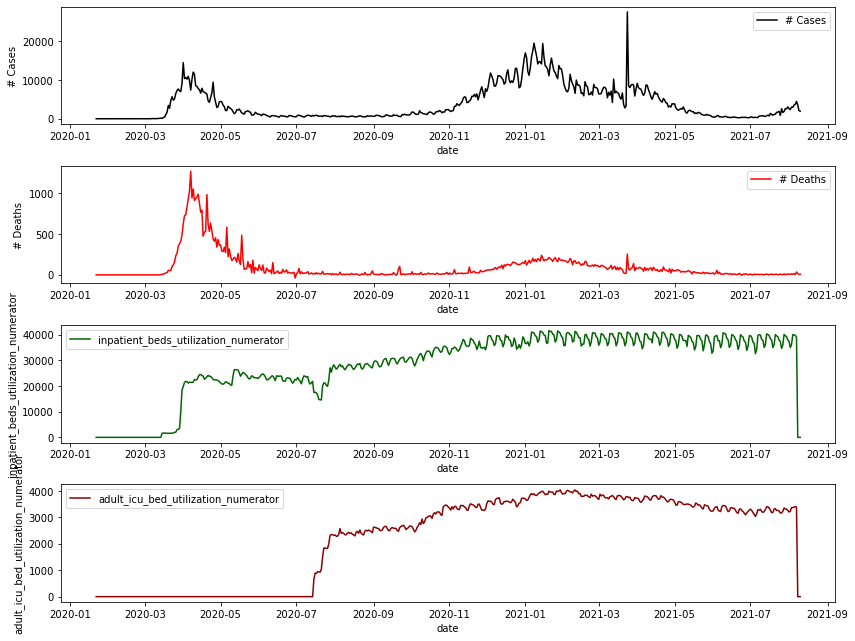

In [34]:
## 3 subplots
fig, axes = plt.subplots(nrows=4,figsize=(12,9))

# 1: cases
sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
             ax=axes[0],label='# Cases')#.plot(ax=axes[0])
# 2: deaths
sns.lineplot(data = df_state,x=df_state.index,color='red',
             y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

# 3: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization_numerator',
            ax=axes[2], color='darkgreen',label='inpatient_beds_utilization_numerator')

# 4: icu utilization
sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization_numerator',
            ax=axes[3], color='darkred',label='adult_icu_bed_utilization_numerator')
plt.tight_layout()

In [35]:
## Appending folder with functions
%load_ext autoreload 
%autoreload 2
import sys
sys.path.append('.')

import functions as fn
# help(fn)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def plot_state(df_state, title='State Covid Statistics',figsize=(10,8)):
    drop_cols = [c for c in df_state.columns if ('numerator' in c)| ('denominator' in c)]
    df_state.drop(columns=drop_cols,inplace=True)
    util_cols = [c for c in df_state.columns if c.endswith('utilization') ]
    other_cols = [c for c in df_state.columns if c not in util_cols]

    ## 3 subplots
    fig, axes = plt.subplots(nrows=4,figsize=figsize)
    fig.suptitle(title)

    # 1: cases
    sns.lineplot(data = df_state,x=df_state.index,color='black', y='# Cases',
                 ax=axes[0],label='# Cases')#.plot(ax=axes[0])
    # 2: deaths
    sns.lineplot(data = df_state,x=df_state.index,color='red',
                 y='# Deaths',ax=axes[1],label='# Deaths')#.plot(ax=axes[0])

    # 3: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='inpatient_beds_utilization',
                ax=axes[2], color='darkgreen',label='inpatient_beds_utilization')

    # 4: icu utilization
    sns.lineplot(data=ny, x=df_state.index, y='adult_icu_bed_utilization',
                ax=axes[3], color='darkred',label='adult_icu_bed_utilization')
    plt.tight_layout()
    return fig

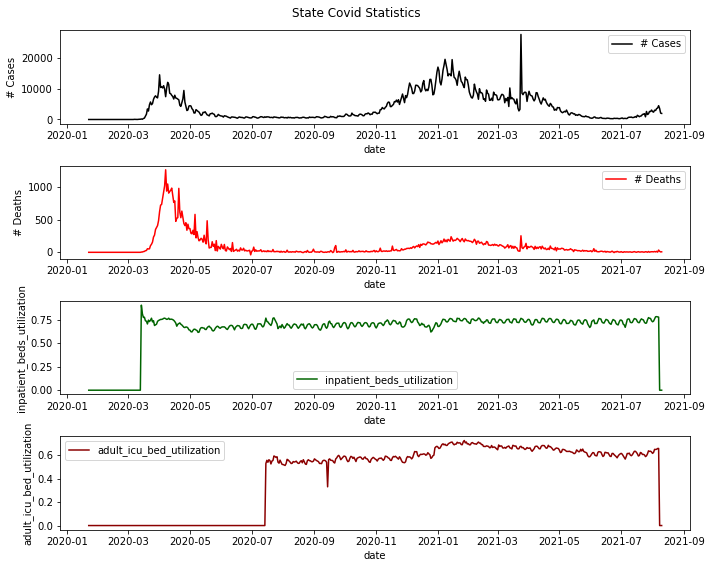

In [38]:
plot_state(ny);

# Time Series Modeling

## Functions

In [46]:
### FORECAST SPECIFIC FUNCTIONS
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sms
import statsmodels.tsa.api as tsa

def get_forecast(model,steps=12):
    pred = model.get_forecast(steps=steps)
    forecast = pred.conf_int()
    forecast.columns = ['Lower CI','Upper CI']
    forecast['Forecast'] = pred.predicted_mean
    return forecast

    
def plot_forecast(model,ts,last_n_lags=52,future_steps=12):
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_lags:].plot(label='True Data')
    forecast_df['Forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['Lower CI'], forecast_df['Upper CI'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    return fig,ax


def evaluate_model(model,ts,last_n_lags =52,steps=12):
    display(model.summary())
    model.plot_diagnostics();
    fig,ax=plot_forecast(model,ts,future_steps=steps,last_n_lags=last_n_lags)
    return fig,ax

In [ ]:
from pmdarima import auto_arima

def get_ts(df,col,fill_val=np.nan,**kwargs):
    ts = df[col].fillna(value=fill_val)
    return ts



def get_best_model(ts,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,
                   as_sarimax = True, **kwargs):
    
    auto_model = auto_arima(ts,start_p=start_p,
                            start_q=start_q,start_P=start_P,start_Q=start_Q,m=m,)
    print(f"[i] Best parameters found:")
    display(auto_model.summary())

    if as_sarimax:
        model = SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
        return model

    else:
        return auto_model

def get_forecast(model,steps=14):
    forecast = model.get_forecast(steps=steps)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.columns = ['lower','upper','forecast']
    return forecast_df

    
def plot_forecast(model,ts,last_n_days=60,future_steps=14):
    forecast_df = get_forecast(model,steps=future_steps)

    fig,ax = plt.subplots(figsize=(12,5))
    ts.iloc[-last_n_days:].plot(label='True Data')
    forecast_df['forecast'].plot(ax=ax)
    ax.fill_between(forecast_df.index,
                    forecast_df['lower'], forecast_df['upper'],alpha=0.6)
    ax.legend()
    ax.set(title=f'Forecasted {ts.name}')
    return fig,ax

## NY

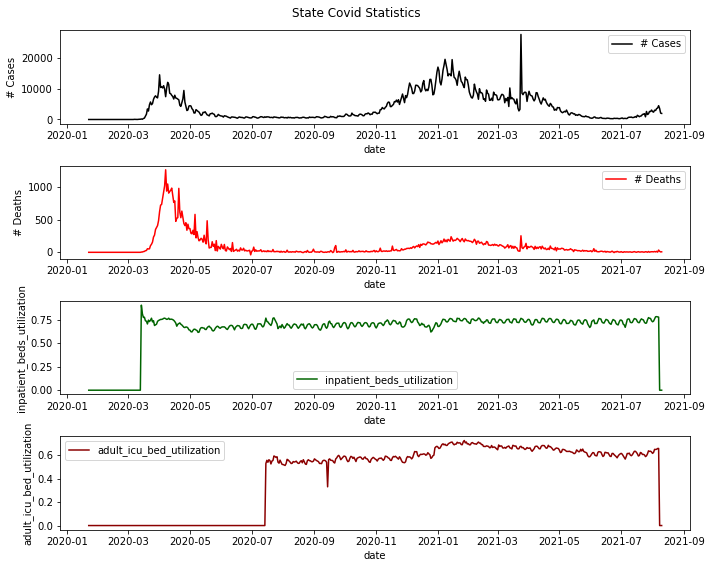

In [47]:
plot_state(ny);

### Checking Seasonal Decompose for Seasonality to Use

<AxesSubplot:xlabel='date'>

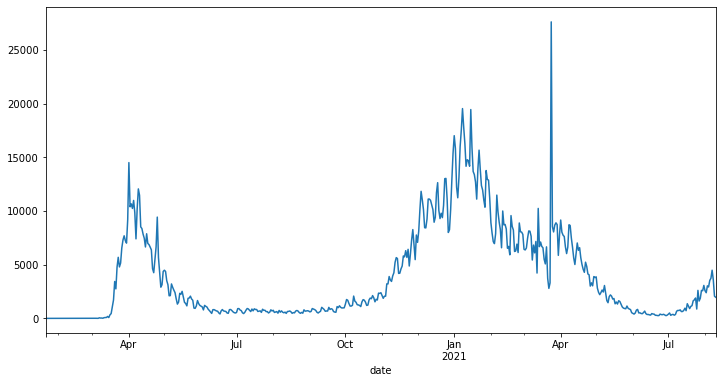

In [49]:
ts = ny['# Cases'].copy()
ts.plot()

### Number of Cases

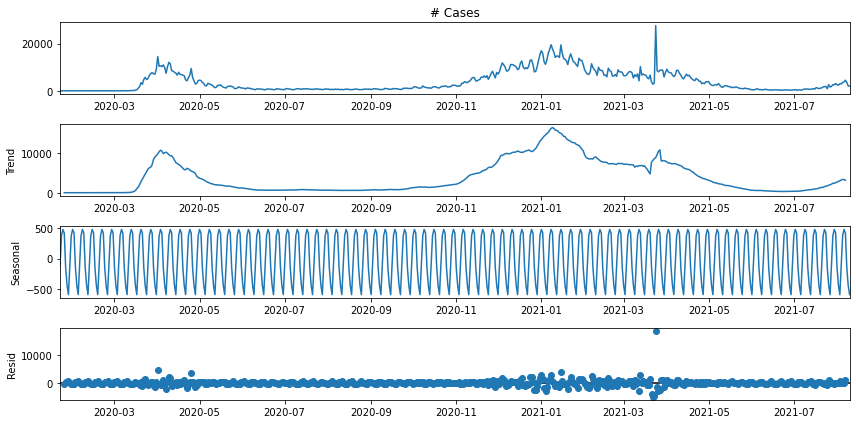

In [50]:
decomp = tsa.seasonal_decompose(ts)
decomp.plot();

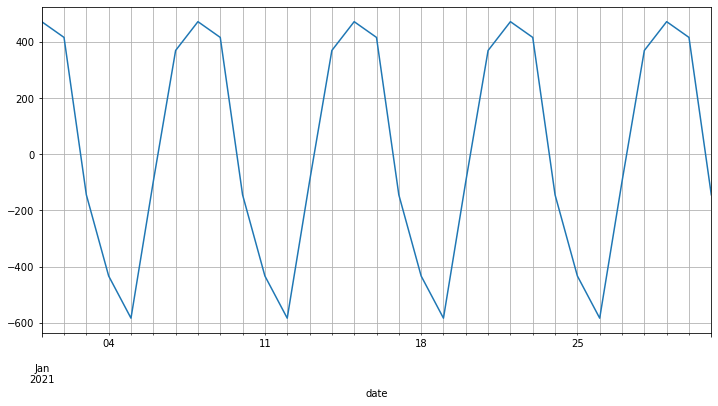

In [53]:
ax = decomp.seasonal.loc['01-2021'].plot()
ax.grid(which='both')

- Seasonality appears to be ~7 days

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.446855,14,545,0.000245,True,True


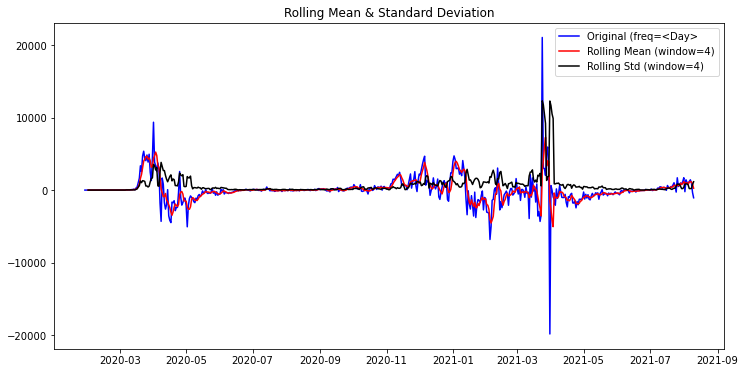

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.446855,14,545,0.000245,True,True


In [63]:
fn.stationarity_check(ts.diff(7).dropna(),window=4)

<AxesSubplot:xlabel='date'>

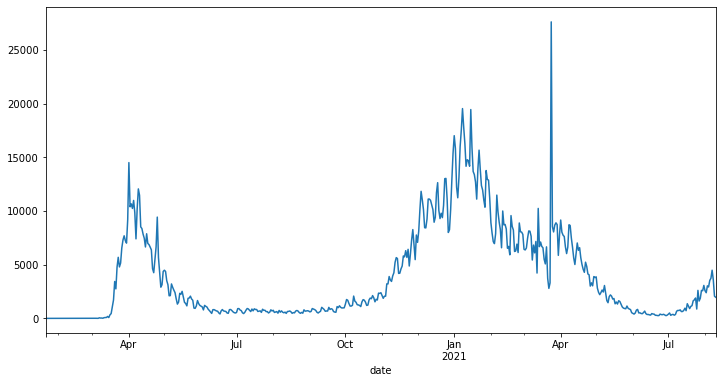

In [64]:
ts.plot()

In [65]:
ts.shape[0]-30

537

In [90]:
def train_test_split_ts(ts,test_size=0.9):
    tts_cutoff = round(ts.shape[0]*0.9)
    fmt = "%m-%d-%Y"
    cutoff_time = ts.index[tts_cutoff]
    print(f"Using a cutoff index of {tts_cutoff}, which = {cutoff_time.strftime(fmt)}")
    
      ## Use the tts cutoff to do Train test split and plot
    train = ts.iloc[:tts_cutoff]
    test = ts.iloc[tts_cutoff:]

    ## Plot
    ax = train.plot(label='train')
    test.plot(label='test')
    ax.legend()
    ax.set(ylabel=ts.name)
    ax.axvline(cutoff_time,color='k',ls=':',label=cutoff_time.strftime(fmt))
    ax.legend()
    return train, test


Using a cutoff index of 510, which = 06-15-2021


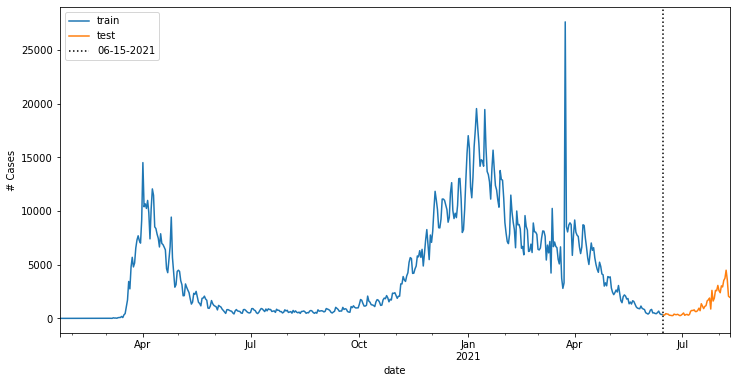

In [91]:
train,test = train_test_split_ts(ts)

In [92]:
# ## train test spit
# # get the tts_cutoff  (the # of timesteps/rows to split at)
# tts_cutoff = round(ts.shape[0]*0.9)
# tts_cutoff

In [93]:
# ## Use the tts cutoff to do Train test split and plot
# train = ts.iloc[:tts_cutoff]
# test = ts.iloc[tts_cutoff:]

# ## Plot
# ax = train.plot(label='train')
# test.plot(label='test')
# ax.legend()

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.219001,14,488,0.000612,True,True


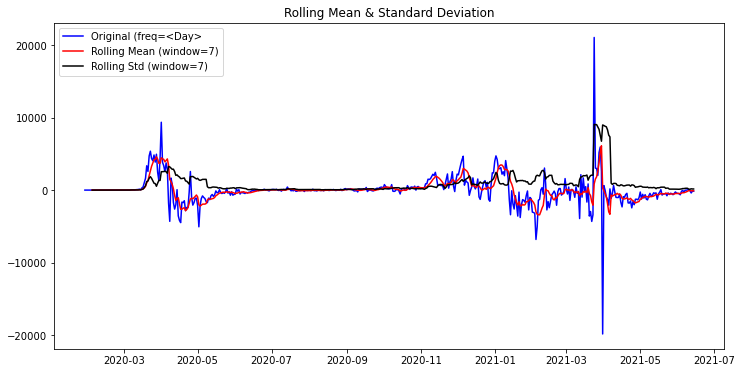

,Test Statistic,#Lags Used,# of Observations Used,p-value,p<.05,Stationary?
AD Fuller Results,-4.219001,14,488,0.000612,True,True


In [95]:
## check staationarity 
fn.stationarity_check(train.diff(7).dropna(), window=7)

In [98]:
from pmdarima import auto_arima

auto_model = auto_arima(train,start_p=0,start_q=0,start_P=0,start_Q=0,m=7,trace=False)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  510
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4435.481
Date:                           Wed, 11 Aug 2021   AIC                           8880.963
Time:                                   10:09:40   BIC                           8902.125
Sample:                                        0   HQIC                          8889.260
                                           - 510                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1549      0.044      3.508      0.000       0.068       0.241
ma.L1         -0.7293      0.045    -16.308      0.000      -0.817      -0.642
ar.S.L7        0.6433      0.096      6.724      0.000       0.456       0.831
ma.S.L7       -0.4121      0.099     -4.173      0.000      -0.606      -0.219
sigma2      2.166e+06   3.26e+04     66.429      0.000     2.1e+06    2.23e+06
===================================================================================
Ljung-Box (Q):                       65.59   Jarque-Bera (JB):            370381.74
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.67   Skew:                             8.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       134.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  510
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4437.677
Date:                           Wed, 11 Aug 2021   AIC                           8885.353
Time:                                   10:09:41   BIC                           8906.515
Sample:                               01-22-2020   HQIC                          8893.651
                                    - 06-14-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1551      0.051      3.071      0.002       0.056       0.254
ma.L1         -0.7293      0.051    -14.254      0.000      -0.830      -0.629
ar.S.L7        0.6422      0.110      5.846      0.000       0.427       0.858
ma.S.L7       -0.4113      0.113     -3.627      0.000      -0.634      -0.189
sigma2      2.478e+06   4.26e+04     58.113      0.000    2.39e+06    2.56e+06
===================================================================================
Ljung-Box (Q):                       65.71   Jarque-Bera (JB):            370321.47
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.67   Skew:                             8.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       134.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

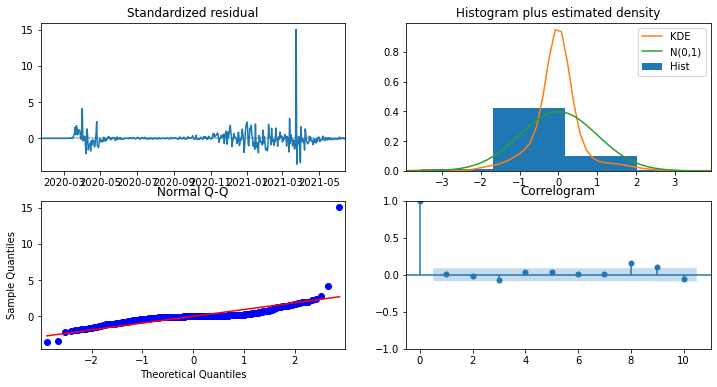

In [99]:
model = tsa.SARIMAX(train,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

# BOOKMARK

In [110]:
def evaluate_model(model,train,test_ts,steps=None):
    fn.diagnose_model(model)
    
    if steps is None:
        steps=len(test_ts)
    
    forecast = model.get_forecast(steps=steps)
    forecast_df = fn.get_df_from_pred(forecast,)
    
    fig, ax = fn.plot_forecast_from_df(forecast_df,ts_diff=ts,
                                    last_n_lags=365)
    
    if test_ts is not None:
        test_ts.plot(ax=ax)
    return fig,ax
           

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  510
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4437.677
Date:                           Wed, 11 Aug 2021   AIC                           8885.353
Time:                                   10:11:48   BIC                           8906.515
Sample:                               01-22-2020   HQIC                          8893.651
                                    - 06-14-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1551      0.051      3.071      0.002       0.056       0.254
ma.L1         -0.7293      0.051    -14.254      0.000      -0.830      -0.629
ar.S.L7        0.6422      0.110      5.846      0.000       0.427       0.858
ma.S.L7       -0.4113      0.113     -3.627      0.000      -0.634      -0.189
sigma2      2.478e+06   4.26e+04     58.113      0.000    2.39e+06    2.56e+06
===================================================================================
Ljung-Box (Q):                       65.71   Jarque-Bera (JB):            370321.47
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               5.67   Skew:                             8.22
Prob(H) (two-sided):                  0.00   Kurtosis:                       134.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

(<Figure size 720x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted # Cases'}, xlabel='date'>)

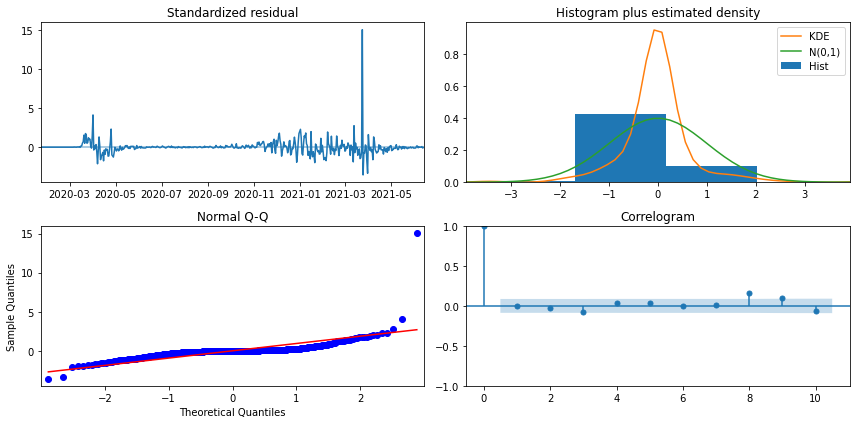

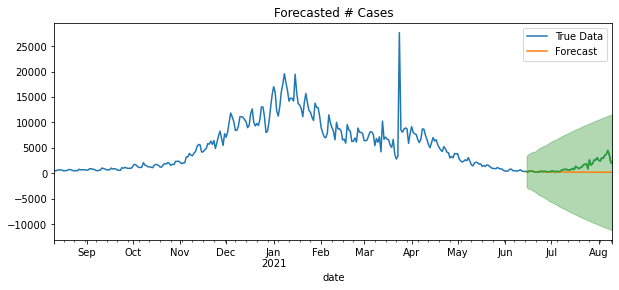

In [111]:
# fn.plot_forecast(model,)
evaluate_model(model,train,test,)

In [ ]:
## Next: if happy, train on entire ts

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                           # Cases   No. Observations:                  567
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4907.241
Date:                           Wed, 11 Aug 2021   AIC                           9824.483
Time:                                   10:12:29   BIC                           9846.175
Sample:                               01-22-2020   HQIC                          9832.949
                                    - 08-10-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1558      0.046      3.395      0.001       0.066       0.246
ma.L1         -0.7286      0.047    -15.647      0.000      -0.820      -0.637
ar.S.L7        0.6437      0.099      6.493      0.000       0.449       0.838
ma.S.L7       -0.4122      0.102     -4.029      0.000      -0.613      -0.212
sigma2      2.247e+06    3.5e+04     64.131      0.000    2.18e+06    2.32e+06
===================================================================================
Ljung-Box (Q):                       72.05   Jarque-Bera (JB):            490272.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.91   Skew:                             8.53
Prob(H) (two-sided):                  0.00   Kurtosis:                       146.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

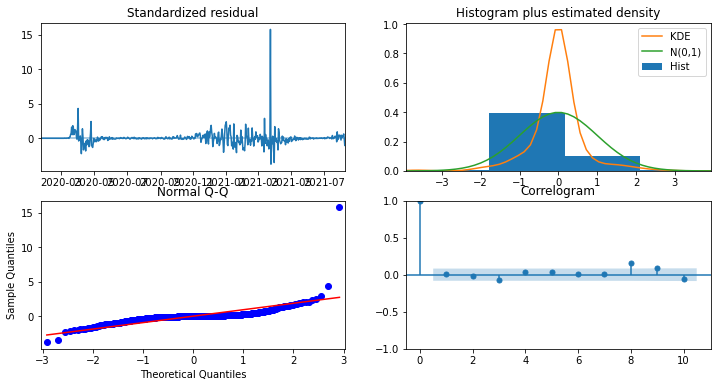

In [112]:
model = tsa.SARIMAX(ts,order=auto_model.order, 
                seasonal_order =auto_model.seasonal_order,
                enforce_invertibility=False,freq='D').fit()
display(model.summary())
model.plot_diagnostics();

(<Figure size 864x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Forecasted # Cases'}, xlabel='date'>)

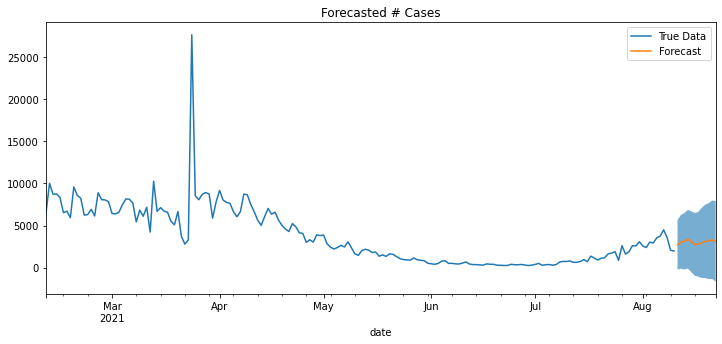

In [114]:
fn.plot_forecast(model, ts,last_n_lags=26*7)

## Old Data

In [39]:
# covid = fn.CovidTrackingProject(verbose=True)
# covid

In [45]:
# covid.df_states

## Updating Workflow Due to CovidTracking Project API shutting down

- Reverting to using Kaggle dataset. 


# UPDATING 

In [32]:
cols_to_grab = ['# Cases','# Deaths','inpatient_beds_utilization','adult_icu_bed_utilization']
df_state = STATES['MD'][cols_to_grab].copy()
df_state

,# Cases,# Deaths,inpatient_beds_utilization,adult_icu_bed_utilization
date,,,,
2020-01-22,0.0,0.0,0.000000,0.000000
2020-01-23,0.0,0.0,0.000000,0.000000
2020-01-24,0.0,0.0,0.000000,0.000000
2020-01-25,0.0,0.0,0.000000,0.000000
2020-01-26,0.0,0.0,0.000000,0.000000
...,...,...,...,...
2021-08-04,695.0,5.0,0.844803,0.736719
2021-08-05,729.0,2.0,0.837001,0.726408
2021-08-06,890.0,4.0,0.841025,0.731073


In [28]:


# ## Get df for curr state and resample, keeping the last point for each day
# state_df = df.loc[df['state']==state]
# state_df = state_df.resample('D').last()

# ## save each col into its own dict key
# state_ts_dict = {}
# for col in cols_to_grab:
#     curr_ts = state_df[col].rename(f"{state}-{col}")
#     state_ts_dict[col] = curr_ts
# state_ts_dict

In [31]:
# cols_to_grab = ['Confirmed','Deaths','Recovered']
# state_data = {}
# for state in state_list:

#     ## Get df for curr state and resample, keeping the last point for each day
#     state_df = df.loc[df['state']==state]
#     state_df = state_df.resample('D').last()

#     ## save each col into its own dict key
#     state_ts_dict = {}
#     for col in cols_to_grab:
#         curr_ts = state_df[col].rename(f"{state}-{col}")
#         state_ts_dict[col] = curr_ts
#     state_data[state] = pd.DataFrame(state_ts_dict)

In [33]:
# ## pull out md confirmed
# ts = state_data['MD']#['Confirmed']
# ts

# TEST MODELING

In [35]:
df_state.columns

Index(['# Cases', '# Deaths', 'inpatient_beds_utilization',
       'adult_icu_bed_utilization'],
      dtype='object')

<AxesSubplot:xlabel='date'>

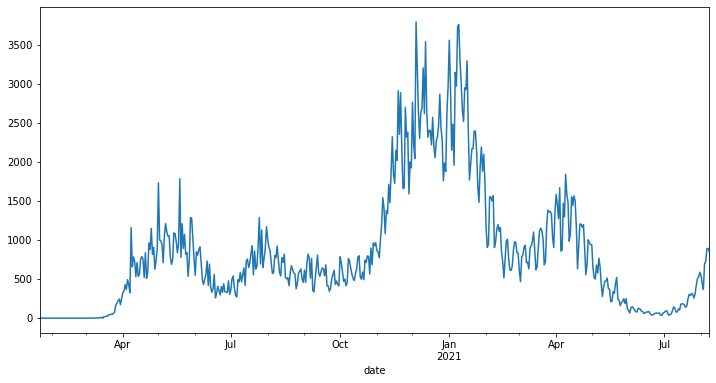

In [37]:
ts = df_state['# Cases']
ts.plot()

<AxesSubplot:xlabel='date'>

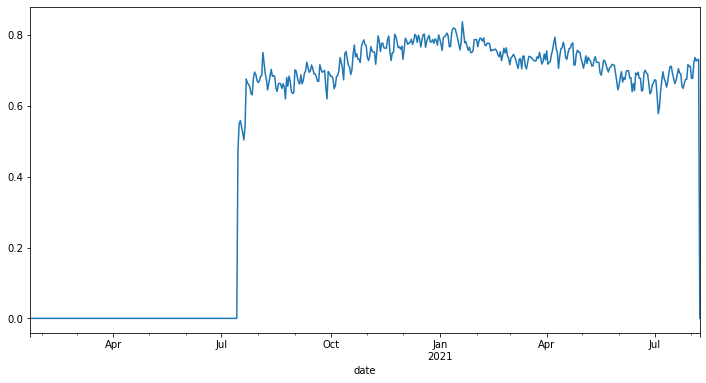

In [39]:
ts2 = df_state['adult_icu_bed_utilization']
ts2.plot()

<AxesSubplot:xlabel='date'>

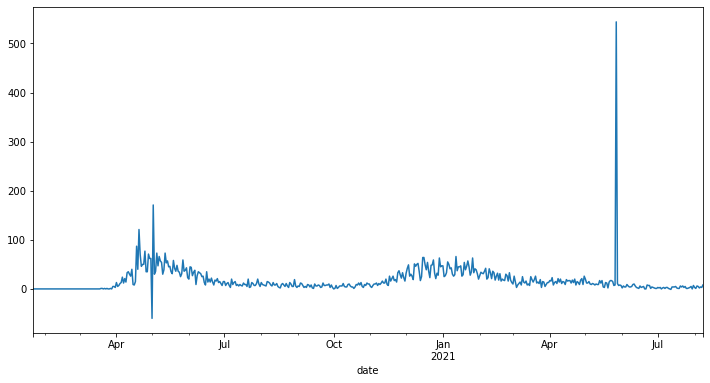

In [38]:
ts3 = df_state['# Deaths']
ts3.plot()

In [52]:
##Getting forecast
forecast = model.get_forecast(steps=14)

forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean
forecast_df.columns = ['lower','upper','forecast']
forecast_df

,lower,upper,forecast
2021-08-09,343.002656,1192.765671,767.884164
2021-08-10,307.683692,1231.798313,769.741002
2021-08-11,364.833640,1357.747777,861.290709
2021-08-12,365.934731,1423.180744,894.557737
2021-08-13,371.837854,1489.719683,930.778768
2021-08-14,347.189270,1522.583006,934.886138
2021-08-15,289.394791,1519.614724,904.504758
2021-08-16,188.213715,1513.767664,850.990690
2021-08-17,157.677119,1547.851160,852.764139
2021-08-18,214.241949,1666.162902,940.202426


[Text(0.5, 1.0, 'Forecasted Hospitalizations (Current) for Maryland')]

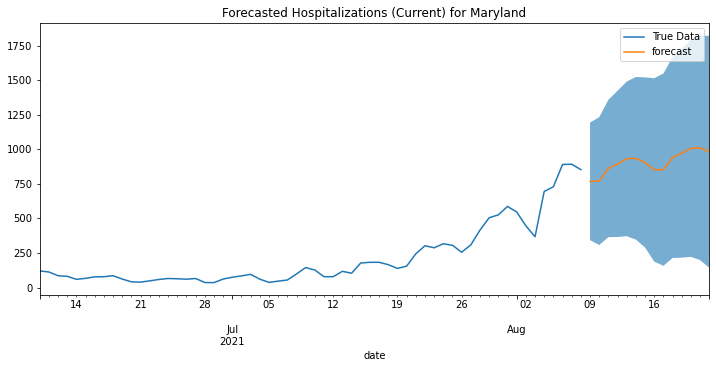

In [53]:
last_n_days = 60
fig,ax = plt.subplots(figsize=(12,5))
ts.iloc[-last_n_days:].plot(label='True Data')
forecast_df['forecast'].plot(ax=ax)
ax.fill_between(forecast_df.index,
                forecast_df['lower'], forecast_df['upper'],alpha=0.6)
ax.legend()
ax.set(title='Forecasted Hospitalizations (Current) for Maryland')
# ax.plot()